In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Layer
from keras.metrics import MeanSquaredError
from keras import backend as K
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train_folder = r'C:\Users\User\Desktop\codes\fer2013\1\train'
test_folder = r'C:\Users\User\Desktop\codes\fer2013\1\test'

In [3]:
class_names = os.listdir(train_folder)
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
X_train = []
X_test = []
data = []

In [5]:
for i in class_names:
    file_path = os.path.join(train_folder, i)
    for img in os.listdir(file_path):
        image_array = cv2.imread(os.path.join(file_path, img), cv2.IMREAD_GRAYSCALE)
        X_train.append(image_array)

In [6]:
print(len(X_train))

28709


In [7]:
X_train = np.array(X_train)


(-0.5, 47.5, 47.5, -0.5)

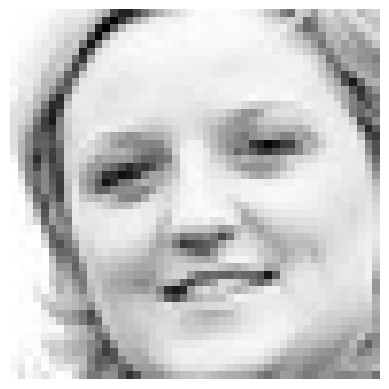

In [8]:
plt.imshow(X_train[10000], cmap= 'gray')
plt.axis('off')

In [9]:
for j in class_names:
    file_path = os.path.join(test_folder, j)
    for img in os.listdir(file_path):
        image_array = cv2.imread(os.path.join(file_path, img), cv2.IMREAD_GRAYSCALE)
        X_test.append(image_array)

In [10]:
X_test = np.array(X_test)

print(X_test.shape)

(7178, 48, 48)


In [ ]:
data = np.concatenate((X_train, X_test), axis = 0)

In [12]:
print(data.shape)

(35887, 48, 48)


In [13]:
data = data.reshape(-1, 48, 48, 1).astype('float32') / 255
print(data.shape)

(35887, 48, 48, 1)


# Manual Training Loop (Custom Training with GradientTape)

🚀 شروع آموزش VAE...
🔄 بررسی داده‌ها...
📊 شکل داده‌ها: (35887, 48, 48, 1)
📊 محدوده داده‌ها: [0.000, 1.000]
🎯 آموزش VAE روی 35887 عکس...
Epoch 0: Loss = 1440.8809
Epoch 5: Loss = 1368.5673
Epoch 10: Loss = 1365.8849
Epoch 15: Loss = 1364.6472
Epoch 20: Loss = 1363.9880
Epoch 25: Loss = 1363.2906
✅ VAE آموزش داده شد!
🎨 تولید 2000 عکس مصنوعی...
✅ تولید شد: (2000, 48, 48, 1)


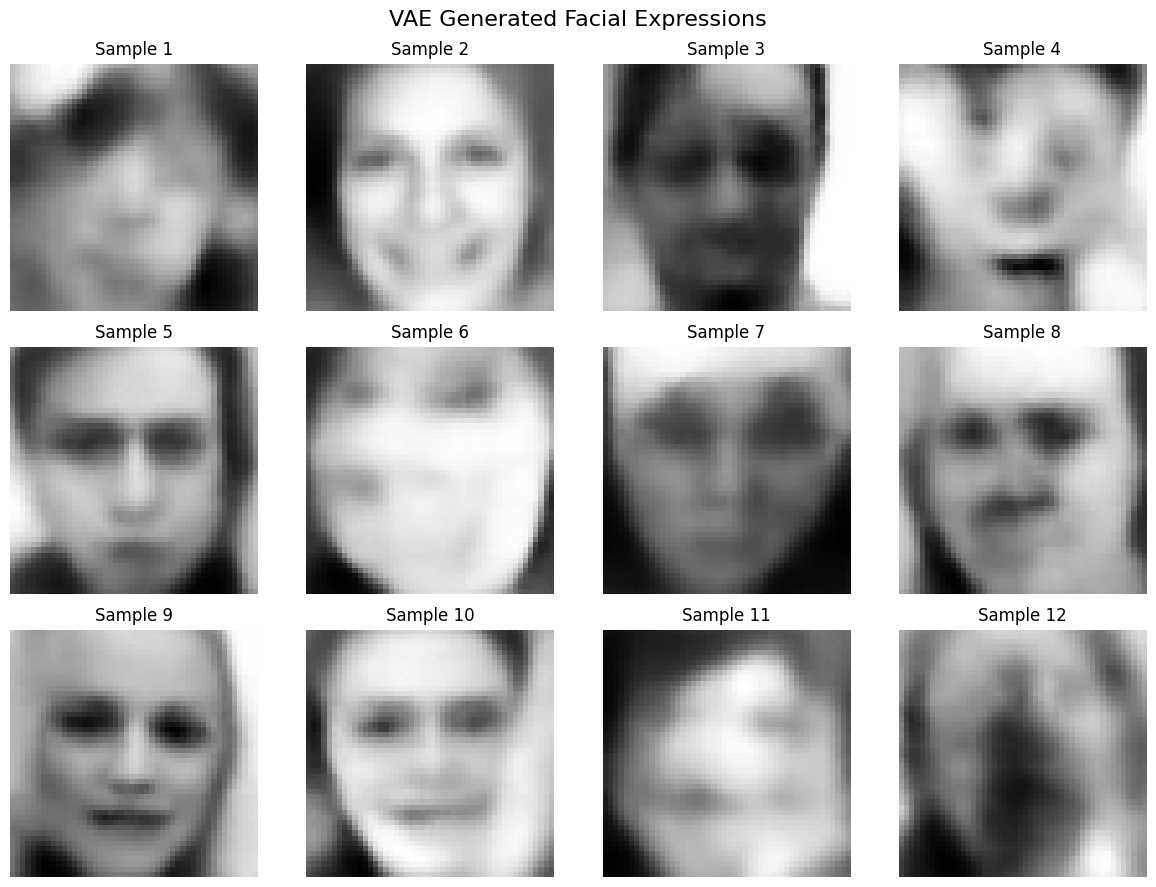

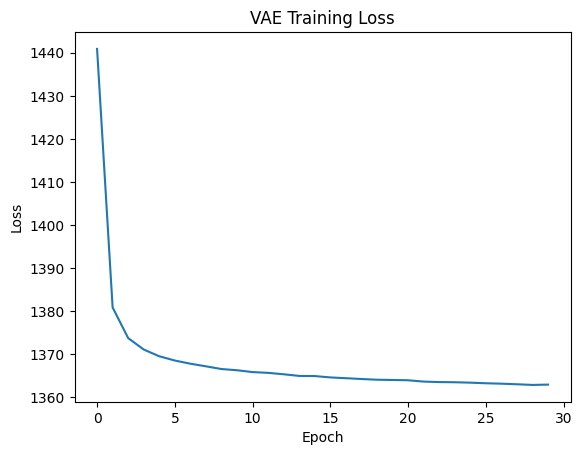

💾 وزن‌های VAE ذخیره شدند!
🎯 داده‌های مصنوعی آماده: (2000, 48, 48, 1)


In [ ]:
from tensorflow.keras import layers, Model


class SimpleVAE(tf.keras.Model):
    def __init__(self, latent_dim=128):
        super(SimpleVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),  # mean + log_var
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(6*6*128, activation='relu'),
            layers.Reshape((6, 6, 128)),
            layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same'),
        ])
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z):
        return self.decoder(z)

def vae_loss(model, x):

    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_reconstructed = model.decode(z)
    

    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_reconstructed),
            axis=(1, 2)
        )
    )
    

    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
    )
    
    return reconstruction_loss + kl_loss

def train_vae_on_all_data(data, epochs=30, batch_size=64):
    """
    آموزش VAE روی تمام داده‌ها
    """
    print(f"🎯 آموزش VAE روی {len(data)} عکس...")
    

    vae = SimpleVAE(latent_dim=64)
    

    optimizer = tf.keras.optimizers.Adam(1e-3)
    

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.batch(batch_size).shuffle(1000)
    


    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for batch in dataset:
            with tf.GradientTape() as tape:
                loss = vae_loss(vae, batch)
            
            gradients = tape.gradient(loss, vae.trainable_variables)
            optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
            
            epoch_loss += loss
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    
    print("✅ VAE آموزش داده شد!")
    return vae, train_losses

def generate_synthetic_images(vae, num_images=1000):
    """
    تولید عکس‌های مصنوعی با VAE آموزش دیده
    """
    print(f"🎨 تولید {num_images} عکس مصنوعی...")
    
    z = tf.random.normal(shape=(num_images, vae.latent_dim))
    
    generated_images = vae.decode(z)
    
    return generated_images.numpy()

def main():
    

    print("🔄 بررسی داده‌ها...")
    
    
    
    print(f"📊 شکل داده‌ها: {data.shape}")
    print(f"📊 محدوده داده‌ها: [{data.min():.3f}, {data.max():.3f}]")
    


    vae_trained, losses = train_vae_on_all_data(
        data, 
        epochs=30, 
        batch_size=64
    )
    
    synthetic_images = generate_synthetic_images(vae_trained, num_images=2000)
    
    print(f"✅ تولید شد: {synthetic_images.shape}")
    
    show_generated_samples(synthetic_images)
    
    plt.plot(losses)
    plt.title('VAE Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return vae_trained, synthetic_images

def show_generated_samples(synthetic_images, num_samples=12):

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    for i in range(min(num_samples, len(synthetic_images))):
        row, col = i // 4, i % 4
        axes[row, col].imshow(synthetic_images[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f'Sample {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('VAE Generated Facial Expressions', fontsize=16)
    plt.tight_layout()
    plt.show()

print("🚀 شروع آموزش VAE...")
vae_model, synthetic_imgs = main()

vae_model.save_weights('vae_fer2013_weights.h5')
print("💾 وزن‌های VAE ذخیره شدند!")


print(f"🎯 داده‌های مصنوعی آماده: {synthetic_imgs.shape}")

In [32]:
class VEA(tf.keras.Model):
    def __init__(self, latent_dim = 128):
        super().__init__()
        self.latetnt_dim = latent_dim


        self.encoder = tf.keras.Sequential(
            [layers.Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same', input_shape = (48, 48, 1)),
            layers.Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same'),
            layers.Conv2D(128, 3, activation = 'relu', strides = 2, padding = 'same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)
             

            ]
        )

        self.decoder = tf.keras.Sequential(
            [
            layers.Dense(6*6*128, activation = 'relu', input_shape = (48, 48, 1) ),
            layers.Reshape((6, 6, 128)),
            layers.Conv2DTranspose(128, 3, activation = 'relu', strides = 2, padding = 'same'),
            layers.Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same'),
            layers.Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same'),
            layers.Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')


            ]
        )

    def encode(self, x):
        mean , logvar = tf.split(self.encoder(x), num_or_size_splits= 2, axis =1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape= mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, x):
        return self.decoder

In [33]:
def vae_loss(model, x):
    mean , logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_reconstructed = model.decode(z)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis= (1,2))
    )

    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
    )
    
    return reconstruction_loss + kl_loss


# Training with model.fit methode

🚀 شروع آموزش VAE با model.fit()...
📊 شکل data شما: (35887, 48, 48, 1)
📊 محدوده data: [0.000, 1.000]
🎯 آموزش VAE روی 35887 عکس...
Epoch 1/30
505/505 [==============================] - 23s 44ms/step - loss: 1433.6206 - reconstruction_loss: 1411.6624 - kl_loss: 21.9582 - val_loss: 1494.0754 - val_reconstruction_loss: 1469.9187 - val_kl_loss: 24.1567
Epoch 2/30
505/505 [==============================] - 22s 44ms/step - loss: 1380.6126 - reconstruction_loss: 1350.3966 - kl_loss: 30.2160 - val_loss: 1491.1730 - val_reconstruction_loss: 1464.8870 - val_kl_loss: 26.2860
Epoch 3/30
505/505 [==============================] - 23s 45ms/step - loss: 1374.3285 - reconstruction_loss: 1342.7043 - kl_loss: 31.6242 - val_loss: 1488.9048 - val_reconstruction_loss: 1462.5073 - val_kl_loss: 26.3974
Epoch 4/30
505/505 [==============================] - 23s 45ms/step - loss: 1371.7640 - reconstruction_loss: 1339.3696 - kl_loss: 32.3944 - val_loss: 1487.2897 - val_reconstruction_loss: 1461.4690 - val_kl_loss:

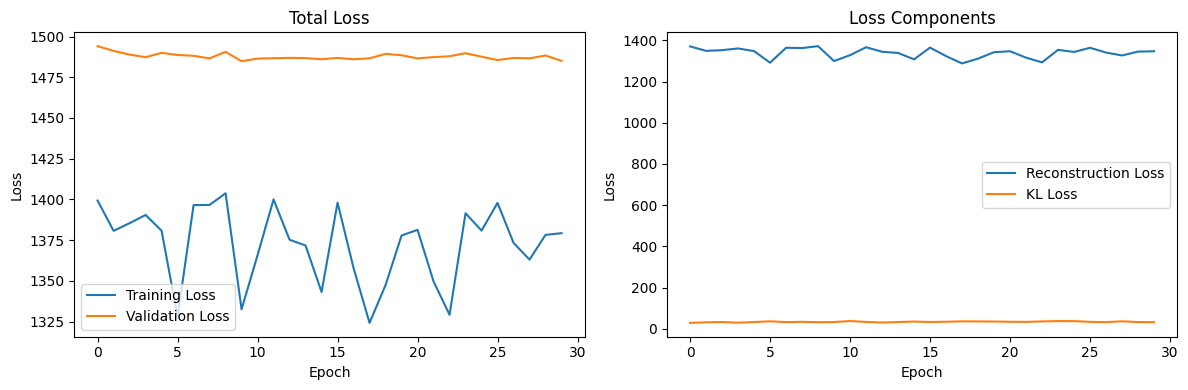

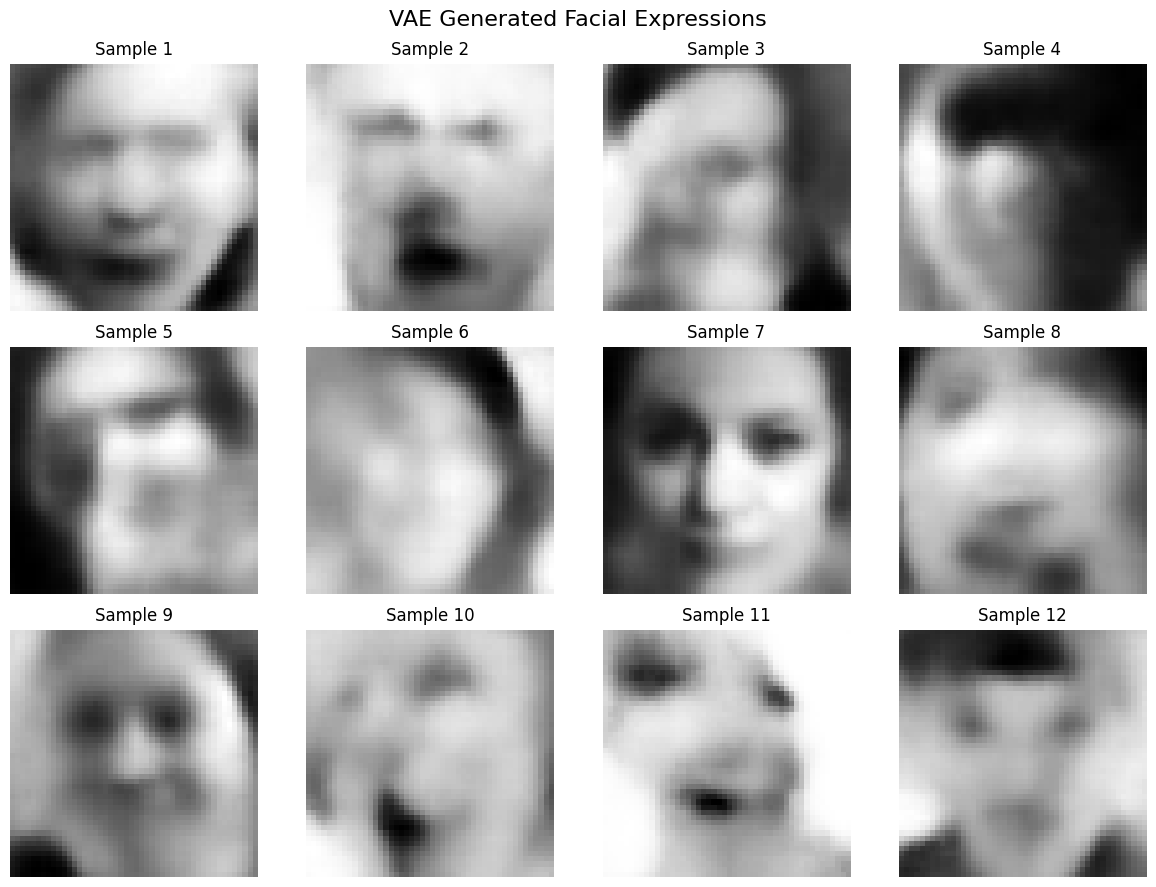

💾 وزن‌های VAE ذخیره شدند!


In [ ]:

class SimpleVAE(tf.keras.Model):
    def __init__(self, latent_dim=64):
        super(SimpleVAE, self).__init__()
        self.latent_dim = latent_dim
        

        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),
        ])
        

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(6*6*128, activation='relu'),
            layers.Reshape((6, 6, 128)),
            layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same'),
        ])
    
    def call(self, inputs, training=False):

        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):

        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, data):

        if isinstance(data, (tuple, list)):
            data = data[0]
            
        with tf.GradientTape() as tape:

            mean, logvar = self.encode(data)
            z = self.reparameterize(mean, logvar)
            x_reconstructed = self.decode(z)
            

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, x_reconstructed),
                    axis=(1, 2)
                )
            )
            
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
            )
            
            total_loss = reconstruction_loss + kl_loss
        

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {
            "loss": total_loss, 
            "reconstruction_loss": reconstruction_loss, 
            "kl_loss": kl_loss
        }
    
    def test_step(self, data):

        if isinstance(data, (tuple, list)):
            data = data[0]
            
        mean, logvar = self.encode(data)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, x_reconstructed),
                axis=(1, 2)
            )
        )
        

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
        )
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss, 
            "reconstruction_loss": reconstruction_loss, 
            "kl_loss": kl_loss
        }

def train_vae_simple(data, epochs=30, batch_size=64):
    
    print(f"🎯 آموزش VAE روی {len(data)} عکس...")
    


    vae = SimpleVAE(latent_dim=64)
    

    vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))
    

    history = vae.fit(
        data,  
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=True,
        verbose=1
    )
    
    print("✅ VAE آموزش داده شد!")
    return vae, history

def generate_synthetic_images(vae, num_images=1000):

    print(f"🎨 تولید {num_images} عکس مصنوعی...")
    

    z = tf.random.normal(shape=(num_images, vae.latent_dim))
    

    generated_images = vae.decoder(z)
    
    return generated_images.numpy()

def show_generated_samples(synthetic_images, num_samples=12):

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    for i in range(min(num_samples, len(synthetic_images))):
        row, col = i // 4, i % 4
        axes[row, col].imshow(synthetic_images[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f'Sample {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('VAE Generated Facial Expressions', fontsize=16)
    plt.tight_layout()
    plt.show()


print("🚀 شروع آموزش VAE با model.fit()...")


print(f"📊 شکل data شما: {data.shape}")
print(f"📊 محدوده data: [{data.min():.3f}, {data.max():.3f}]")


vae_model, history = train_vae_simple(data, epochs=30, batch_size=64)


synthetic_images = generate_synthetic_images(vae_model, num_images=2000)
print(f"✅ تولید شد: {synthetic_images.shape}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
if 'reconstruction_loss' in history.history:
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
if 'kl_loss' in history.history:
    plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

show_generated_samples(synthetic_images)

vae_model.save_weights('vae_fer2013_weights.h5')
print("💾 وزن‌های VAE ذخیره شدند!")